# Elliptic AML Dataset Exploration
Initial exploration and visualization of the dataset.

In [ ]:
import os, json, numpy as np, pandas as pd
from pathlib import Path
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

DATA_RAW = Path("../data/raw")
DATA_INTERIM = Path("../data/interim")      
DATA_PROCESSED = Path("../data/processed")  # for modelling
# 复制一份原始数据做对比
for p in [DATA_INTERIM, DATA_PROCESSED]: p.mkdir(parents=True, exist_ok=True)

### 2. 加载与完整性校验
校验三件套：elliptic_txs_features.csv, elliptic_txs_edgelist.csv, elliptic_txs_classes.csv 
检查：形状、重复 txId、空值、取值域；edges_df 的节点是否都在 classes_df 里

In [8]:
features = pd.read_csv(DATA_RAW/"elliptic_txs_features.csv", header=None)
edges    = pd.read_csv(DATA_RAW/"elliptic_txs_edgelist.csv")
classes  = pd.read_csv(DATA_RAW/"elliptic_txs_classes.csv")

assert features.shape[0] == classes.shape[0]
assert classes['txId'].is_unique

# 空值/重复
nulls = features.isna().sum().sum()
dups_edges = edges.duplicated().sum()
print(f"NULLs in features: {nulls}, duplicate edges: {dups_edges}")

# 边的端点是否都在类表中
assert set(edges['txId1']).issubset(set(classes['txId']))
assert set(edges['txId2']).issubset(set(classes['txId']))

NULLs in features: 0, duplicate edges: 0


### 3. 标签清洗与映射
	•	建议：保留三类问题两套数据：
A) 二分类（丢弃 unknown）→ 给监督学习
B) 半监督/异常检测（unknown 保留）→ 给 One-Class/IF/GNN 半监督
	•	建议映射：{'illicit':1, 'licit':0}，unknown 先丢或单独存

In [9]:
# 合并 txId
features['txId'] = classes['txId']

label_map = {'1':1, 1:1, '2':0, 2:0, 'unknown':np.nan}
y_raw = classes['class'].map(label_map)

mask_sup = y_raw.notna()
y_sup = y_raw[mask_sup].astype(int)

# 仅监督学习子集
feat_sup = features.loc[mask_sup].reset_index(drop=True)
y_sup = y_sup.reset_index(drop=True)

### 4. 基础特征工程与清洗
丢掉常数/近零方差特征

可选：对高缺失/极端值做处理（你的 features 通常无缺失）

共线筛选（>0.98 的相关性只保留其一）

In [10]:
# 除 txId 外的原始数值列
num_cols = [c for c in feat_sup.columns if c not in ['txId']]

# 常数列
nunique = feat_sup[num_cols].nunique()
keep = nunique[nunique > 1].index.tolist()
feat_sup = feat_sup[['txId'] + keep]

# 高相关去重
corr = feat_sup[keep].corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.98)]
feat_sup = feat_sup.drop(columns=to_drop)
print(f"dropped {len(to_drop)} highly correlated columns")

dropped 46 highly correlated columns


这一步的意义：

为什么要做：在金融反欺诈里，匿名特征可能是经过派生的衍生指标，有些是强相关/完全重复的，这会导致模型（特别是树模型、逻辑回归）在训练时过拟合或出现冗余计算。
阈值 0.98：说明只剔除了几乎完全相同的特征，而不是把相似性较高但有独立信息的特征也删掉，比较稳妥。

影响：

数据维度下降（内存/计算速度提升）
消除了完全共线性风险（尤其是后面如果用逻辑回归）

所以，这这之后我打算：

在 02_preprocessing.ipynb 里把被删掉的列名保存一下（方便写报告时说明 “共删除46列高度相关特征”）。
清洗完后的 feat_sup 保存到 processed/ 文件夹，命名如 features_dedup.parquet。
在报告里画一个特征相关性热力图（去重前 vs 去重后），方便直观展示维度缩减的效果。

(rebuild) dropped 48 highly correlated columns


,n_features_before,n_features_after,memory_before_MB,memory_after_MB,mean_abs_corr_before,mean_abs_corr_after
0,167,119,259.620000,185.000000,0.074438,0.069971


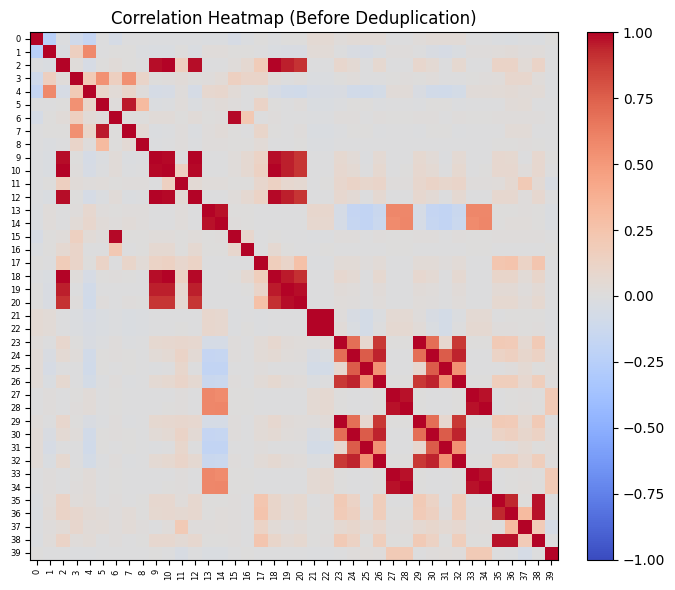

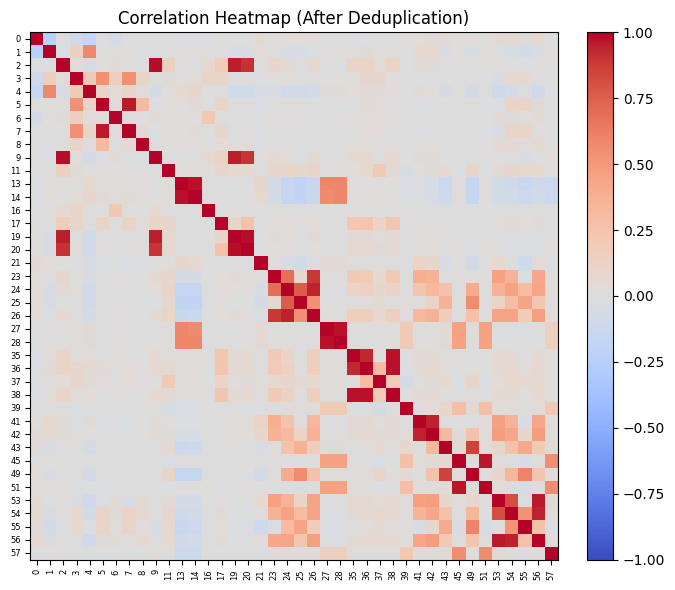

Saved dropped columns list -> data/processed/dropped_highcorr_cols.txt


ArrowKeyError: No type extension with name arrow.py_extension_type found

In [15]:
# === Quick fix: rebuild "before dedup" safely and continue ===
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) 用原始 features / classes 重建去重前矩阵
feat_rebuild = features.copy()
feat_rebuild['txId'] = classes['txId']

num_cols0 = [c for c in feat_rebuild.columns if c != 'txId']
nunique0 = feat_rebuild[num_cols0].nunique()
keep0 = nunique0[nunique0 > 1].index.tolist()

feat_before = feat_rebuild[['txId'] + keep0].copy()
X_before = feat_before.drop(columns=['txId'])

# 2) 在“同一宇宙”里重新计算 to_drop，得到 X_after（干净矩阵）
corr0 = X_before.corr().abs()
upper0 = corr0.where(np.triu(np.ones(corr0.shape), k=1).astype(bool))
to_drop0 = [col for col in upper0.columns if any(upper0[col] > 0.98)]

X_after = X_before.drop(columns=to_drop0)
remaining0 = [c for c in X_before.columns if c not in to_drop0]

print(f"(rebuild) dropped {len(to_drop0)} highly correlated columns")

# 3) 前后对比表
def mem_mb(df): 
    return round(df.memory_usage(deep=True).sum() / 1024**2, 2)

compare = pd.DataFrame({
    "n_features_before": [X_before.shape[1]],
    "n_features_after":  [X_after.shape[1]],
    "memory_before_MB":  [mem_mb(X_before)],
    "memory_after_MB":   [mem_mb(X_after)],
    "mean_abs_corr_before": [np.nanmean(np.abs(X_before.corr().values))],
    "mean_abs_corr_after":  [np.nanmean(np.abs(X_after.corr().values))]
})
display(compare.style.background_gradient(axis=None, cmap="Blues"))

# 4) 相关性热力图（抽样前40列）
def plot_corr_heatmap(X, title, max_cols=40):
    cols = X.columns[:max_cols]
    corr = X[cols].corr()
    plt.figure(figsize=(8, 6))
    im = plt.imshow(corr, cmap="coolwarm", vmin=-1, vmax=1)
    plt.title(title)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks(range(len(cols)), cols, rotation=90, fontsize=6)
    plt.yticks(range(len(cols)), cols, fontsize=6)
    plt.tight_layout()
    plt.show()

plot_corr_heatmap(X_before, "Correlation Heatmap (Before Deduplication)")
plot_corr_heatmap(X_after,  "Correlation Heatmap (After Deduplication)")

# 5) 保存：drop 列清单 + 清洗后的特征 parquet
DATA_PROCESSED = Path("data/processed")
DATA_PROCESSED.mkdir(parents=True, exist_ok=True)

with open(DATA_PROCESSED / "dropped_highcorr_cols.txt", "w") as f:
    for col in to_drop0:
        f.write(f"{col}\n")
print(f"Saved dropped columns list -> {DATA_PROCESSED/'dropped_highcorr_cols.txt'}")

out_feat = pd.concat([feat_before[['txId']], X_after], axis=1)
out_path = DATA_PROCESSED / "features_dedup.parquet"
out_feat.to_parquet(out_path, index=False)
print(f"Saved deduplicated features -> {out_path}")


In [16]:
# ---- normalize dtypes (avoid pandas extension types) ----
numeric_like = out_feat.select_dtypes(include=["number", "bool"]).columns.tolist()
other_cols   = [c for c in out_feat.columns if c not in numeric_like]

# Cast numerics to float64/int64, others to plain object/string to avoid Arrow extension types
out_feat[numeric_like] = out_feat[numeric_like].apply(pd.to_numeric, errors="coerce")
for c in other_cols:
    out_feat[c] = out_feat[c].astype("object")

# Paths
parquet_path = DATA_PROCESSED / "features_dedup.parquet"
csv_path     = DATA_PROCESSED / "features_dedup.csv"

# Try saving with different engines, then fallback to CSV
saved = False
try:
    out_feat.to_parquet(parquet_path, index=False, engine="pyarrow")
    print(f"✅ Saved parquet (pyarrow) -> {parquet_path}")
    saved = True
except Exception as e1:
    print("⚠️ pyarrow failed:", repr(e1))
    try:
        out_feat.to_parquet(parquet_path, index=False, engine="fastparquet")
        print(f"✅ Saved parquet (fastparquet) -> {parquet_path}")
        saved = True
    except Exception as e2:
        print("⚠️ fastparquet failed:", repr(e2))

if not saved:
    out_feat.to_csv(csv_path, index=False)
    print(f"➡️ Fallback: saved CSV -> {csv_path}")


⚠️ pyarrow failed: ArrowKeyError('A type extension with name pandas.period already defined')
⚠️ fastparquet failed: ImportError("Missing optional dependency 'fastparquet'. fastparquet is required for parquet support. Use pip or conda to install fastparquet.")
➡️ Fallback: saved CSV -> data/processed/features_dedup.csv


### 5. 时序信息与切分

Elliptic 数据自带 time step（通常在 features 第 0 列），建议基于时间切分：
	•	训练：前 70% 的时间步
	•	验证：中间 10%
	•	测试：最后 20%

In [ ]:
# 通常 features 第0列为 timestep（请确认你的版本）
timestep_col = 0
df = feat_sup.copy()
df['timestep'] = df[timestep_col]

# 对齐标签
df['label'] = y_sup

# 排序后切分
df = df.sort_values('timestep').reset_index(drop=True)
ts = df['timestep'].values

t1 = np.quantile(ts, 0.7)
t2 = np.quantile(ts, 0.8)

train_idx = df['timestep'] <= t1
valid_idx = (df['timestep'] > t1) & (df['timestep'] <= t2)
test_idx  = df['timestep'] > t2

train, valid, test = df[train_idx], df[valid_idx], df[test_idx]
print(train.shape, valid.shape, test.shape)

### 6. 标准化/缩放（仅在训练集拟合）（Code）
	•	强烈建议用 sklearn 的 Pipeline 保存 scaler，并只用训练集拟合

In [ ]:
from sklearn.preprocessing import StandardScaler

feature_cols = [c for c in df.columns if c not in ['txId','label','timestep']]
scaler = StandardScaler()

X_train = train[feature_cols].copy()
X_valid = valid[feature_cols].copy()
X_test  = test[feature_cols].copy()

scaler.fit(X_train)
X_train_s = scaler.transform(X_train)
X_valid_s = scaler.transform(X_valid)
X_test_s  = scaler.transform(X_test)

y_train = train['label'].values
y_valid = valid['label'].values
y_test  = test['label'].values

7. 类别不平衡处理（思路）
	•	基线：模型里用 class_weight='balanced'
	•	采样：如果要用 SMOTE/Under-sampling，只在训练集做
	•	替代：Focal Loss（在后续 03_modeling/深度模型中再上）

在预处理阶段先不做采样，避免把选择“写死”到数据层；把采样放到建模 Pipeline 更灵活。


把可训练矩阵与对照表、scaler 参数、列名、切分边界全部存起来。

In [ ]:
import joblib

# 保存矩阵（推荐 parquet 或 npy）
pd.DataFrame(X_train_s, columns=feature_cols).to_parquet(DATA_PROCESSED/"X_train.parquet")
pd.DataFrame(X_valid_s, columns=feature_cols).to_parquet(DATA_PROCESSED/"X_valid.parquet")
pd.DataFrame(X_test_s,  columns=feature_cols).to_parquet(DATA_PROCESSED/"X_test.parquet")

pd.Series(y_train).to_frame("label").to_parquet(DATA_PROCESSED/"y_train.parquet")
pd.Series(y_valid).to_frame("label").to_parquet(DATA_PROCESSED/"y_valid.parquet")
pd.Series(y_test).to_frame("label").to_parquet(DATA_PROCESSED/"y_test.parquet")

# 保存切分用到的 txId，方便做图/回溯
train[['txId','timestep']].to_parquet(DATA_INTERIM/"train_ids.parquet")
valid[['txId','timestep']].to_parquet(DATA_INTERIM/"valid_ids.parquet")
test[['txId','timestep']].to_parquet(DATA_INTERIM/"test_ids.parquet")

# 保存 scaler 与元数据
joblib.dump(scaler, DATA_PROCESSED/"scaler.joblib")
meta = {
    "random_seed": RANDOM_SEED,
    "dropped_high_corr": to_drop,
    "feature_cols": feature_cols,
    "timestep_quantiles": {"train<=q0.7": float(t1), "valid<=q0.8": float(t2)},
    "samples": {"train": int(len(train)), "valid": int(len(valid)), "test": int(len(test))}
}
with open(DATA_PROCESSED/"metadata.json", "w") as f:
    json.dump(meta, f, indent=2)

9. 质量闸（QA）与可复现性
	•	检查各 split 标签比例
	•	检查没有数据泄漏（验证/测试与训练的时间边界）
	•	固定随机种子；记录依赖版本（pip freeze > requirements.txt）

In [ ]:
for name, y in [("train", y_train), ("valid", y_valid), ("test", y_test)]:
    unique, counts = np.unique(y, return_counts=True)
    print(name, dict(zip(unique, counts)))